# SVM Practice Session
In this session, we will see how to use Support Vector Machines (SVM) to classify data. In a first time, we will work with generated data, and then we will use SVM to try and predict pulsars stars.

## Imports

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Data generation

In [10]:
# We generate 1000 points, with 2 features, and 2 classes
# Let's pick a center for each class
center1 = np.array([0, 0])
center2 = np.array([1, 1])
# We generate 500 points around each center, distributed normally
data1 = np.random.normal(loc=center1, # mean
                         scale=(0.5, 0.3), # std deviation
                         size=(500, 2))
data2 = np.random.normal(loc=center2, # mean
                         scale=(0.3, 0.5), # std deviation
                         size=(500, 2))
# We create the labels
labels1 = np.zeros(500)
labels2 = np.ones(500)
# We concatenate the data and the labels
data1 = np.concatenate((data1, labels1.reshape(-1, 1)), axis=1)
data2 = np.concatenate((data2, labels2.reshape(-1, 1)), axis=1)
# We concatenate the two classes
data = np.concatenate((data1, data2), axis=0)
# We shuffle the data
np.random.shuffle(data)
# We split the data into train, and test sets (80% / 20 %)
train, test = train_test_split(data, test_size=0.2, stratify=data[:, 2])
# (optional)
# We make a dataframe to plot the data, with columns x, y, label, set
df = pandas.DataFrame(data, columns=['Feature1', 'Feature2', 'Label'])
# We save the data
# df.to_csv('data.csv', index=False)


Let's plot the data, to see what it looks like

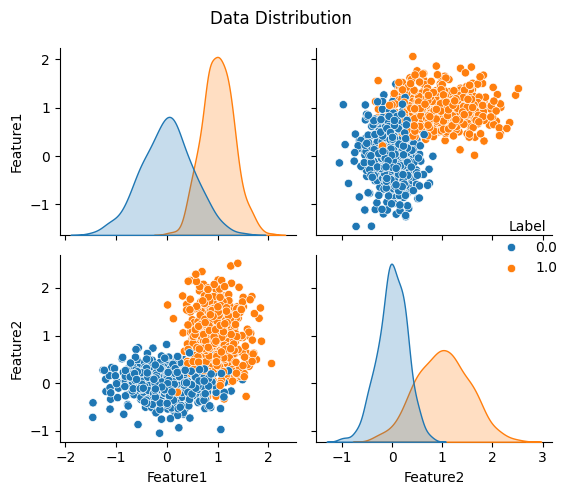

In [11]:
sns.pairplot(df, hue='Label')
plt.suptitle('Data Distribution')
plt.tight_layout()
plt.show()

## SVM 

Note : use the GridSearchCV() function from sklearn to find the best hyperparameters for the SVM model.
In order to plot the results of the grid search, you may consider heatmaps.
Howerever, you may notice that we are concidering 3 hyperparameters, which makes it impossible to plot in a 2D space, and a 3D heatmap may be hard to read.
Hence, you may consider plotting only 2 hyperparameters at a time, and average over the third one !

To get the results from GridSearchCV, you may use `grid.cv_results_["mean_test_score"]` and `grid.cv_results_["params"]` to get the mean test score and the hyperparameters used for each fold.
A 'nice' way of getting a unified collection of the hyperparameters and their corresponding score would be a peice of code such as :
```python
d = []
i=0
for p in grid.cv_results_["params"]:
    d.append(p)
    d[-1]["result"] = grid.cv_results_["mean_test_score"][i]
    i += 1
print(d)
``` 

In [35]:
# We tune the hyperparameters : C, kernel, gamma
param_grid = {
	'kernel': ['poly', 'rbf'],
	'gamma': [0.01, 0.1, 0.5, 1],
	'C': [0.01, 0.1, 1, 10, 100, 1000, 10000],
}

# We make a classifier
clf = svm.SVC()

# We make a grid search using GridSearchCV()
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Note: the cross-validation behind GridSearchCV automatically splits the data into
# training and validation sets for each fold. It trains the model on the training set and
# evaluates its performance on the validation set. This process is repeated for each fold,
# and the average performance is used to assess the model's generalization ability.
# GridSearchCV exhaustively tests all possible combinations of hyperparameters specified
# in the hyperparams dictionary, and selects the combination that gives the best average
# performance across all folds. This helps in finding the optimal hyperparameters for the
# Support Vector Machine model without manually trying each combination.

# We train it
grid_search.fit(train[:, :2], train[:, 2])

# We print the best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# We select the best model and print the accuracy on the test set
print('Accuracy on the train set:', grid_search.best_estimator_.score(train[:, :2], train[:, 2]))
print('Accuracy on the test set:', grid_search.best_estimator_.score(test[:, :2], test[:, 2]))

Best hyperparameters: {'C': 1000, 'gamma': 0.5, 'kernel': 'rbf'}
Accuracy on the train set: 0.95875
Accuracy on the test set: 0.96


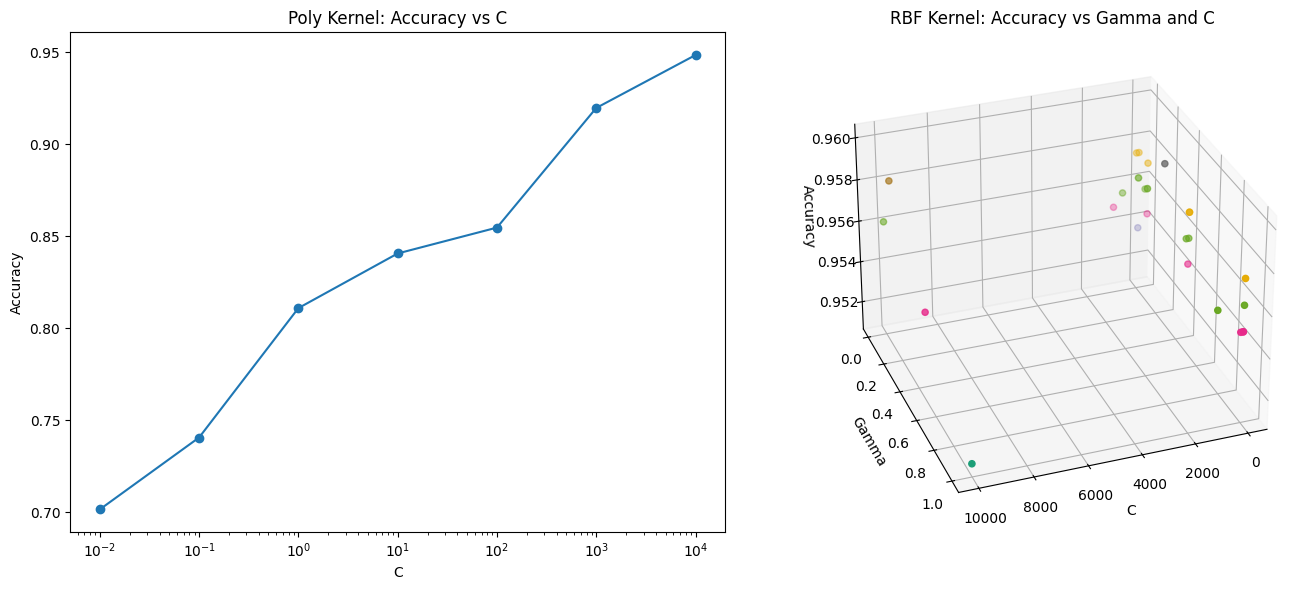

In [36]:
from mpl_toolkits.mplot3d import Axes3D

# Extract the results from the grid search
results = grid_search.cv_results_

# Convert results to a DataFrame
results_df = pandas.DataFrame(results['params'])
results_df['mean_test_score'] = results['mean_test_score']

# Separate the results for the 'poly' and 'rbf' kernels
poly_results_df = results_df[results_df['kernel'] == 'poly']
rbf_results_df = results_df[results_df['kernel'] == 'rbf']

# Group by 'C' and calculate the mean accuracy for the 'poly' kernel
poly_grouped = poly_results_df.groupby('C')['mean_test_score'].mean().reset_index()
poly_C = poly_grouped['C']
poly_results = poly_grouped['mean_test_score']

# Group by 'C' and 'gamma' and calculate the mean accuracy for the 'rbf' kernel
rbf_grouped = rbf_results_df.groupby(['C', 'gamma'])['mean_test_score'].mean().reset_index()
rbf_C = rbf_grouped['C']
rbf_gamma = rbf_grouped['gamma']
rbf_results = rbf_grouped['mean_test_score']

# Create the subplots
fig = plt.figure(figsize=(14, 6))

# Plot the poly kernel results
ax1 = fig.add_subplot(121)
ax1.plot(poly_C, poly_results, marker='o')
ax1.set_xscale('log')
ax1.set_xlabel('C')
ax1.set_ylabel('Accuracy')
ax1.set_title('Poly Kernel: Accuracy vs C')

# Plot the rbf kernel results
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(rbf_C, rbf_gamma, rbf_results, c=rbf_results, cmap='Dark2')
ax2.view_init(elev=30, azim=70)
ax2.set_xlabel('C')
ax2.set_ylabel('Gamma')
ax2.set_zlabel('Accuracy')
ax2.set_title('RBF Kernel: Accuracy vs Gamma and C')

plt.tight_layout()
plt.show();

Text(0.5, 0.92, 'RBF Kernel: Accuracy vs Gamma and C')

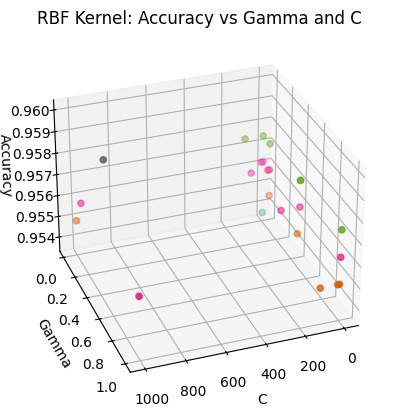

In [33]:
ax2 = plt.subplot(projection='3d')
ax2.scatter(rbf_C, rbf_gamma, rbf_results, c=rbf_results, cmap='Dark2')
# ax2.set_xscale('log')
# ax2.set_xscale('log')
ax2.view_init(elev=30, azim=70)
ax2.set_xlabel('C')
ax2.set_ylabel('Gamma')
ax2.set_zlabel('Accuracy')
ax2.set_title('RBF Kernel: Accuracy vs Gamma and C')

## We can also plot the decision boundary

For better insight, we plot the decision boundary of the classifier with the hyperparameters : (C=1, kernel="linear"), (C=1, kernel="rbf"), (C=100, kernel="linear"), (C=100, kernel="rbf")

In [ ]:
models = {1: {'C': 1, 'kernel': 'linear'},
          2: {'C': 1, 'kernel': 'rbf'},
          3: {'C': 100, 'kernel': 'linear'},
          4: {'C': 100, 'kernel': 'rbf'}}
# We make the classifiers
# We train them
# We get the accuracy on the test set


Note : In order to predict the full space xx, yy, you will need to use something as 
```python
model.predict(np.c_[xx.ravel(), yy.ravel()])
```
Please, note the use of `np.c_` to concatenate the two arrays, and the use of `ravel()` to flatten the arrays.

In [ ]:
# We create a grid of points
x_min, x_max = data[:, 0].min() - 0.1, data[:, 0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# We plot the decision boundary for each classifier and print the accuracy on the test set


for key, value in models.items():
    # We predict the labels for each point in the grid
    # We reshape the predictions to match the grid
    # We plot the decision boundary
    # We plot the data
    

# Note: the model has been trained on the whole training set for each plot, that's why we do not get the exact same test accuracy as with the grid search (which used cross-validation).

## Real data - Pulsar stars

Apply the same procedure as in the previous section to find the best parameters for the pulsar dataset using cross-fold validation. The data is to be found with along to this notebook. The files are :
- pulsar_data_train.csv on which you must perform the training and validation
- pulsar_data_test.csv on which you must test your model.
The interest of having a separate 'test' file is that everybody can eveluate their model equialy. 
Competitions websites such as Kaggle keep there test dataset private to evaluate all participants' models on the same secrete data !

### Description

Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the interstellar medium, and states of matter. Machine learning tools are now being used to automatically label pulsar candidates to facilitate rapid analysis. In particular, classification systems are widely adopted, which treat the candidate datasets as binary classification problems.

### Heandling missing values

Somes values of the features are missing. You can use the `SimpleImputer` from `sklearn.impute` to fill the missing values. Or any other method you prefer.

You can load the data into a dataframe using the below code snippet:

```python
import pandas as pd
input_file = "pulsar_data_train.csv"
df = pd.read_csv(input_file)
```

### More information

Refer to the project's instructions for more information on this part.

In [ ]:
# TODO : Here you go ! Good luck ! :)







